In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import datetime as dt
import time 
import seaborn as sns 
from matplotlib.ticker import PercentFormatter
import calendar
import matplotlib.ticker as ticker
from PIL import * 
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from sklearn.metrics import r2_score
import statsmodels.formula.api as smf
from matplotlib.colors import LinearSegmentedColormap
import scipy.stats as stats
from statsmodels.stats.weightstats import ttest_ind
from scipy.stats import mannwhitneyu

In [2]:
jma_dat = pd.read_csv("jma_data19512021.csv")
jma_dat.shape

(126064, 29)

In [3]:
#goal: remove extratropical cyclones from the data

nature_ind = jma_dat[jma_dat["NATURE"] == "ET"].index
jma_dat.drop(nature_ind, inplace = True)
jma_dat.shape

(114262, 29)

In [4]:
jma_dat["ISO_TIME"] = pd.to_datetime(jma_dat["ISO_TIME"])
jma_dat['time'] = jma_dat["ISO_TIME"].dt.time

In [5]:
#make the data 6-hourly
int_6h = jma_dat[(jma_dat["time"] == dt.time(0,0,0)) | (jma_dat["time"] == dt.time(6,0,0))
                | (jma_dat["time"] == dt.time(12,0,0)) | (jma_dat["time"] == dt.time(18,0,0)) ].index
jma_dat = jma_dat.loc[int_6h]

In [6]:
jma_dat['Month'] = jma_dat["ISO_TIME"].dt.month
jma_dat['month'] = jma_dat["Month"].apply(lambda x: calendar.month_abbr[x])

jma_dat["diff_24h"] = -jma_dat.groupby("SID")["TOKYO_WIND"].diff(-4)
jma_dat["diff_18h"] = -jma_dat.groupby("SID")["TOKYO_WIND"].diff(-3)
jma_dat["diff_12h"] = -jma_dat.groupby("SID")["TOKYO_WIND"].diff(-2)
jma_dat["diff_6h"] = -jma_dat.groupby("SID")["TOKYO_WIND"].diff(-1)

jma_dat["wind_24"] = jma_dat.groupby("SID")["TOKYO_WIND"].shift(-4)
jma_dat["wind_18"] = jma_dat.groupby("SID")["TOKYO_WIND"].shift(-3)
jma_dat["wind_12"] = jma_dat.groupby("SID")["TOKYO_WIND"].shift(-2)
jma_dat["wind_6"] = jma_dat.groupby("SID")["TOKYO_WIND"].shift(-1)

jma_dat["d1"] = jma_dat["wind_6"] - jma_dat["TOKYO_WIND"]
jma_dat["d2"] = jma_dat["wind_12"] - jma_dat["wind_6"]
jma_dat["d3"] = jma_dat["wind_18"] - jma_dat["wind_12"]
jma_dat["d4"] = jma_dat["wind_24"] - jma_dat["wind_18"]

jma_dat["dist_24h"] = jma_dat.groupby("SID")["DIST2LAND"].shift(-4)
jma_dat["dist_18h"] = jma_dat.groupby("SID")["DIST2LAND"].shift(-3)
jma_dat["dist_12h"] = jma_dat.groupby("SID")["DIST2LAND"].shift(-2)
jma_dat["dist_6h"] = jma_dat.groupby("SID")["DIST2LAND"].shift(-1)


In [7]:
jma_dat.tail()

,SID,SEASON,NUMBER,BASIN,SUBBASIN,NAME,ISO_TIME,NATURE,LAT,LON,...,wind_12,wind_6,d1,d2,d3,d4,dist_24h,dist_18h,dist_12h,dist_6h
126055,2020353N06129,2020,113,WP,MM,KROVANH,2020-12-24 00:00:00,TS,7.55000,103.950,...,19.971852,24.523240,4.551388,-4.551388,-5.488707,0.0,47.0,74.0,158.0,166.0
126057,2020353N06129,2020,113,WP,MM,KROVANH,2020-12-24 06:00:00,TS,7.65000,102.800,...,14.483145,19.971852,-4.551388,-5.488707,0.000000,NaN,NaN,47.0,74.0,158.0
126059,2020353N06129,2020,113,WP,MM,KROVANH,2020-12-24 12:00:00,TS,8.15000,101.750,...,14.483145,14.483145,-5.488707,0.000000,NaN,NaN,NaN,NaN,47.0,74.0
126061,2020353N06129,2020,113,WP,MM,KROVANH,2020-12-24 18:00:00,TS,8.65714,100.771,...,NaN,14.483145,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,47.0
126063,2020353N06129,2020,113,NI,BB,KROVANH,2020-12-25 00:00:00,TS,9.74000,99.600,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Percentile 

In [8]:
def myround(x, base = 5):
    return base*round(x/base)

In [9]:
perc = jma_dat[(jma_dat["DIST2LAND"] > 100) & (jma_dat["dist_24h"] > 100) &
                  (jma_dat["dist_18h"] > 100) &  (jma_dat["dist_12h"] > 100)
                  &  (jma_dat["dist_6h"] > 100) &
                  (jma_dat["diff_24h"] < 0)]
perc = perc.sort_values(by = "diff_24h", ascending = True)
perc["round5_24h"] = perc["diff_24h"].apply(myround)
perc["mag_24hw"] = perc["round5_24h"].apply(np.abs)
r05 = perc.mag_24hw.replace(0,5)
perc.update(r05)

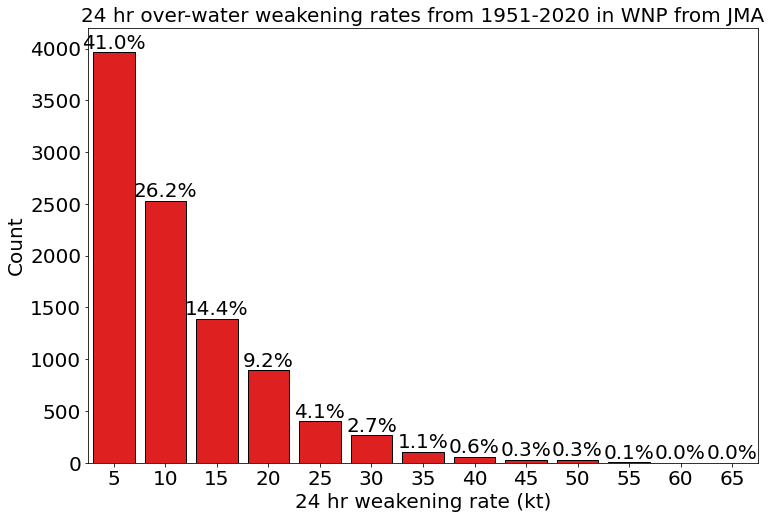

In [10]:
ncount = len(perc)
plt.figure(figsize = (12,8))
ax = sns.countplot(x="mag_24hw",data = perc, color ="red", edgecolor = "black")
plt.xlabel("24 hr weakening rate (kt)", fontsize = 20)
plt.ylabel("Count", fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y), 
            ha='center', va='bottom', fontsize = 20) # set the alignment of the text

#ax.set_ylim(0,1050)
plt.ylim(0, 4200)
plt.title("24 hr over-water weakening rates from 1951-2020 in WNP from JMA", fontsize = 20)
plt.show()

In [11]:
jma_dat.shape

(57659, 48)

In [12]:
perc.shape

(9667, 50)

### Rapid Weakening

In [13]:
threshold = jma_dat[(jma_dat["DIST2LAND"] > 100) & (jma_dat["dist_24h"] > 100) &
                  (jma_dat["dist_18h"] > 100) &  (jma_dat["dist_12h"] > 100)
                  &  (jma_dat["dist_6h"] > 100)  & (jma_dat["diff_6h"] <= 0)
                & (jma_dat["diff_12h"] <= 0)   & (jma_dat["diff_18h"] <= 0)
                 & (jma_dat["diff_24h"] <= -20) & (jma_dat["d1"] <=0)  & (jma_dat["d2"] <=0) 
                    & (jma_dat["d3"] <=0)  & (jma_dat["d4"] <=0)].index #threshold

In [14]:
jma_dat.SID.nunique()

1867

In [15]:
#rapid weakening data
jmadata = jma_dat.loc[threshold]
jmadata.SID.nunique()

468

In [16]:
jmadata["date_diff_rw"] = jmadata.groupby("SID")["ISO_TIME"].diff()
jmadata["diff_sec_rw"] = jmadata["date_diff_rw"]/np.timedelta64(1,"s") #to convert to seconds

uniq_ind = jmadata[(jmadata["diff_sec_rw"] > 86400) | (jmadata["diff_sec_rw"].isna()) ].index
jma_filtered = jmadata.loc[uniq_ind]

In [17]:
jma_filtered.SID.nunique()

468

In [18]:
RW_TC = jmadata["SID"].unique().tolist()
jma_data = jma_dat[jma_dat["SID"].isin(RW_TC)] #TC data of all RW TCs 
jma_data.shape

(17094, 48)

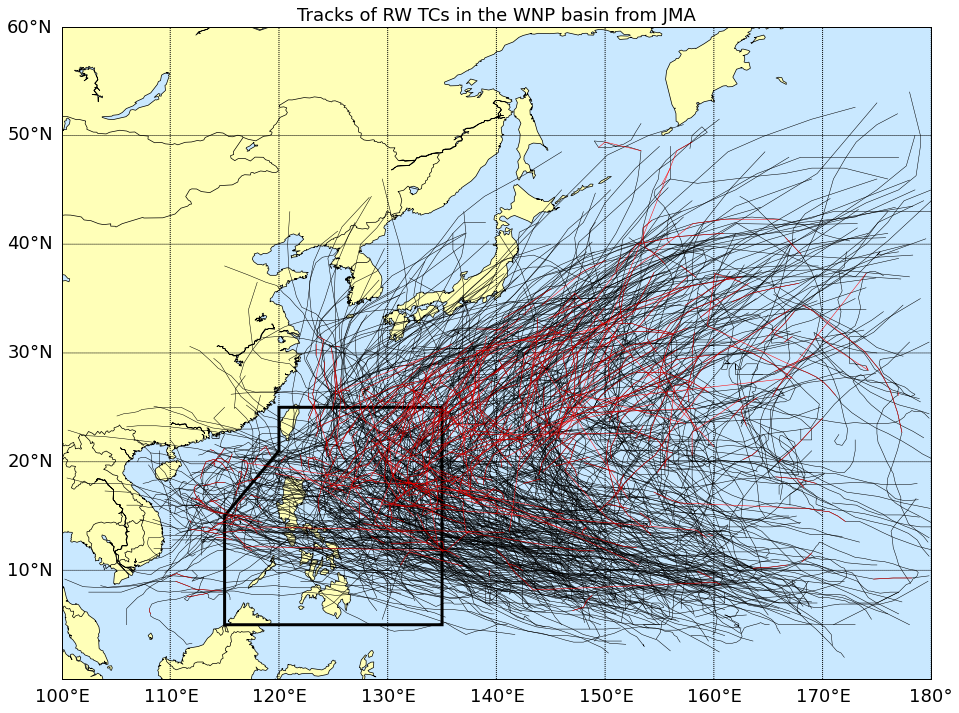

In [19]:
lon_ind = jma_data[(jma_data["TOKYO_LON"] >= 100) & (jma_data["TOKYO_LON"] <= 180)].index
jma_lon = jma_data.loc[lon_ind]

lon_jmadata = jmadata[(jmadata["TOKYO_LON"] >= 100) & (jmadata["TOKYO_LON"] <= 180)].index
jmadata_lon = jmadata.loc[lon_jmadata]

plt.figure(figsize = (18,12))
m = Basemap(projection = 'cyl', llcrnrlat=0,urcrnrlat=60, llcrnrlon=100,urcrnrlon=180,lat_ts = 20, resolution='l')
m.drawcoastlines(linewidth = 0.7)
m.drawmapboundary(fill_color = "#c9e8ff")
m.drawcountries(linewidth = 0.7)
#m.drawstates(linewidth = 0.5)
m.fillcontinents(color='#ffffb8')
m.drawparallels(np.arange(10,90,10),labels=[1,0,0,0], fontsize = 18)
m.drawmeridians(np.arange(-180,180,10),labels=[0,0,0,1], fontsize = 18)

x1, y1 = m(115, 5)
x2, y2 = m(115, 15)
x3, y3 = m(120, 21)
x4, y4 = m(120, 25)
x5, y5 = m(125, 25)
x6, y6 = m(135, 25)
x7, y7 = m(135, 5)
x8, y8 = m(115, 5)

#x_par = [115, 115, 120, 120, 125, 135,135, 115]
#y_par =[5, 15, 21, 35, 35, 35, 5, 5]
poly = Polygon([(x1,y1), (x2,y2), (x3,y3), (x4,y4), (x5,y5), (x6,y6), (x7,y7), (x8,y8)],facecolor ="None", edgecolor='black',linewidth=3)
plt.gca().add_patch(poly)

for name, group in jma_lon.groupby("SID"):
    lat = group.TOKYO_LAT.values 
    lon = group.TOKYO_LON.values
    x,y = m(lon, lat)
    plt.plot(x,y, 'k-', linewidth = 0.5)

for name1, group1 in jmadata_lon.groupby("SID"):
    lat = group1.TOKYO_LAT.values 
    lon = group1.TOKYO_LON.values
    x1,y1 = m(lon, lat)
    plt.plot(x1,y1, 'r-', linewidth = 0.5)

plt.title("Tracks of RW TCs in the WNP basin from JMA", fontsize = 18)
plt.show()

In [20]:
cmap1 = LinearSegmentedColormap.from_list("wgyr", ["w", "g", "y", "r"], N = 256)

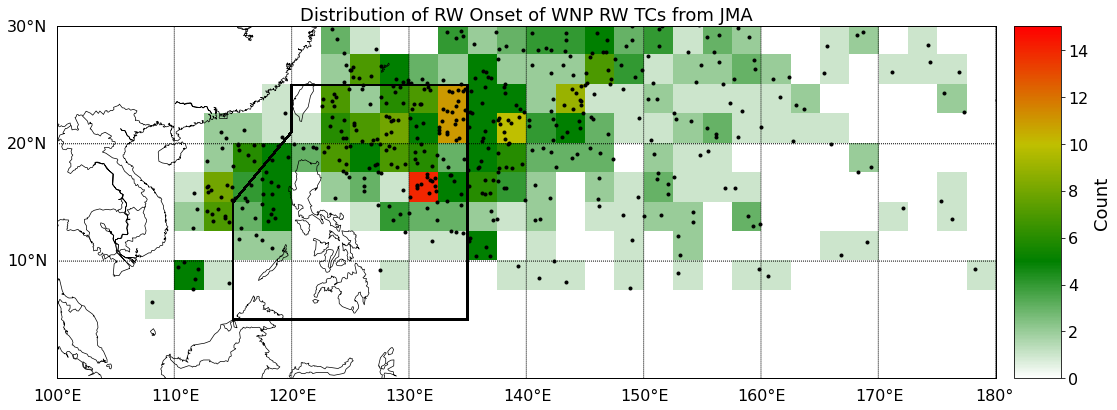

In [21]:
# has a 2.5 x 2.5 degree resolution 
plt.figure(figsize = (18, 12))
m = Basemap(projection = 'cyl', llcrnrlat=0,urcrnrlat=30, llcrnrlon=100,urcrnrlon=180,lat_ts = 20, resolution='l')
m.drawcoastlines(linewidth = 0.7)
m.drawmapboundary()
#m.drawcountries(linewidth = 0.7)
#m.drawstates(linewidth = 0.5)
#m.fillcontinents()
m.drawmapboundary(fill_color = "#c9e8ff")
m.drawcountries(linewidth = 0.7)
#m.drawstates(linewidth = 0.5)
m.fillcontinents(color='#ffffb8')

m.drawparallels(np.arange(10,90,10),labels=[1,0,0,0], fontsize = 16)
m.drawmeridians(np.arange(-180,180,10),labels=[0,0,0,1], fontsize = 16)


x_par = [115, 115, 120, 120, 125, 135,135, 115]
y_par =[5, 15, 21, 25, 25, 25, 5, 5]



Lon = jma_filtered.TOKYO_LON.values
Lat = jma_filtered.TOKYO_LAT.values 
nx, ny = 32, 12
lon_bins = np.linspace(100,180,nx+1)
lat_bins = np.linspace(0,30,ny+1)
density, _, _ = np.histogram2d(Lon,Lat,[lon_bins,lat_bins])

a = m.imshow(density.T, interpolation='none', vmin = 0, vmax=15, alpha=1, cmap=cmap1, zorder=1)
cbar = m.colorbar(a,'right')
cbar.set_label(label = "Count", size = 18)
cbar.ax.tick_params(labelsize = 16) 

for lons, lats in zip(Lon, Lat):
    x, y = m.projtran(lons,lats)
    m.plot(x,y, color = "k", marker = "o", markersize = 3)#bd3020
    m.plot(x_par, y_par, "k-")

plt.title("Distribution of RW Onset of WNP RW TCs from JMA", fontsize = 18)
plt.show()

In [22]:
jma_filtered.shape

(531, 50)

In [23]:
# for all PH landfalling TCs (RW and non-RW)
landfall_tc = jma_dat[(jma_dat["DIST2LAND"] >=0) &(jma_dat["DIST2LAND"] <= 25.4) & (jma_dat["TOKYO_LON"] < 130) & (jma_dat["TOKYO_LON"] > 115) & (jma_dat["TOKYO_LAT"]>5) & (jma_dat["TOKYO_LAT"] <=21)].index
landfall_tcs = jma_dat.loc[landfall_tc]
landfall_tcs.SID.nunique()

446

In [24]:
landfall_tcs["V3"] = landfall_tcs["TOKYO_WIND"].apply(lambda x: x**3)
landfall_tcs[["SEASON", "NAME", "ISO_TIME","DIST2LAND", "TOKYO_LAT", "TOKYO_LON", "TOKYO_WIND", "V3"]].head(115)

,SEASON,NAME,ISO_TIME,DIST2LAND,TOKYO_LAT,TOKYO_LON,TOKYO_WIND,V3
213,1951,IRIS,1951-05-04 18:00:00,10,11.5,125.6,104.096776,1.128007e+06
215,1951,IRIS,1951-05-05 00:00:00,0,11.9,124.8,97.272698,9.203921e+05
217,1951,IRIS,1951-05-05 06:00:00,24,12.5,124.0,89.970304,7.282786e+05
219,1951,IRIS,1951-05-05 12:00:00,24,13.0,123.4,82.072225,5.528262e+05
223,1951,IRIS,1951-05-06 00:00:00,0,14.0,121.7,62.730655,2.468536e+05
...,...,...,...,...,...,...,...,...
8600,1956,GILDA,1956-09-19 06:00:00,11,13.6,123.7,48.920979,1.170807e+05
8785,1956,JEAN,1956-10-21 00:00:00,0,17.3,121.8,83.559405,5.834263e+05
8787,1956,JEAN,1956-10-21 06:00:00,21,17.4,120.4,52.392794,1.438185e+05
8870,1956,KAREN:LUCILLE,1956-11-15 12:00:00,0,16.2,121.9,57.767838,1.927784e+05


In [25]:
lf_pdi =landfall_tcs["V3"].sum()
print("pdi =", lf_pdi)
print(lf_pdi/446)

pdi = 217736938.32933718
488199.41329447797


In [26]:
t1 = landfall_tcs["SID"].unique().tolist()
tt1 = jma_dat[jma_dat["SID"].isin(t1)]

t2 = tt1[tt1.groupby("SID")["DIST2LAND"].apply(lambda x: x.shift().le(25.4).cumsum().eq(0))]
thx = t2[(t2["DIST2LAND"] > 100) & (t2["dist_24h"] > 100) &
                  (t2["dist_18h"] > 100) &  (t2["dist_12h"] > 100)
                  &  (t2["dist_6h"] > 100)  & (t2["diff_6h"] <= 0)
                & (t2["diff_12h"] <= 0)   & (t2["diff_18h"] <= 0)
                 & (t2["diff_24h"] <= -20) & (t2["d1"] <= 0) & (t2["d2"] <= 0)
        & (t2["d3"] <= 0) & (t2["d4"] <= 0)].index
tt2 = t2.loc[thx]
tt2.SID.nunique() #number of landfalling RW TCs in PH

17

In [27]:
tt2.to_csv("lf_rw_jma.csv")
jma_filtered.to_csv("rwtc_jma.csv")

In [28]:
uns =tt2["SID"].unique().tolist()

In [29]:
landfall_rw_ph = tt2["SID"].unique().tolist()
landfall_rwtcs_ph = landfall_tcs[landfall_tcs["SID"].isin(landfall_rw_ph)]
landfall_nonrwtcs_ph = landfall_tcs[~landfall_tcs["SID"].isin(landfall_rw_ph)]
landfall_nonrwtcs_ph.SID.nunique()

429

In [30]:
tt3 = t2[t2["SID"].isin(uns)]
tt4 = t2[~t2["SID"].isin(uns)]
print(tt3.shape)
print(tt4.shape)

(611, 48)
(6169, 48)


In [31]:
rwpdi = landfall_rwtcs_ph["V3"].sum()
nonrwpdi = landfall_nonrwtcs_ph["V3"].sum()
print("rw_pdi =", rwpdi )
print("nonrw_pdi =", nonrwpdi )
print(rwpdi/17)
print(nonrwpdi/429)

rw_pdi = 5902202.771310147
nonrw_pdi = 211834735.55802703
347188.39831236156
493787.2623730234


In [32]:
landfall_ind = jma_data[(jma_data["DIST2LAND"] >=0) & (jma_data["DIST2LAND"] <= 25.4) & (jma_data["TOKYO_LON"] < 130) & (jma_data["TOKYO_LON"] > 120) & (jma_data["TOKYO_LAT"]>5) & (jma_data["TOKYO_LAT"] <20)].index
landfall_phrw = jma_data.loc[landfall_ind]

landfall_rw = landfall_phrw["SID"].unique().tolist()
landfall_rwtcs = jma_filtered[jma_filtered["SID"].isin(landfall_rw)]
land_rwtcs = landfall_rwtcs[(landfall_rwtcs["TOKYO_LON"] > 125)  & (landfall_rwtcs["TOKYO_LAT"] < 21)]
land_rwtcs.SID.nunique()

18

In [33]:
lan1 = tt2["SID"].unique().tolist()
land1 = t2[~t2["SID"].isin(lan1)]
print(land1.SID.nunique())

lan2 = tt2["SID"].unique().tolist()
land2 = t2[t2["SID"].isin(lan2)]
print(land2.SID.nunique())

429
17


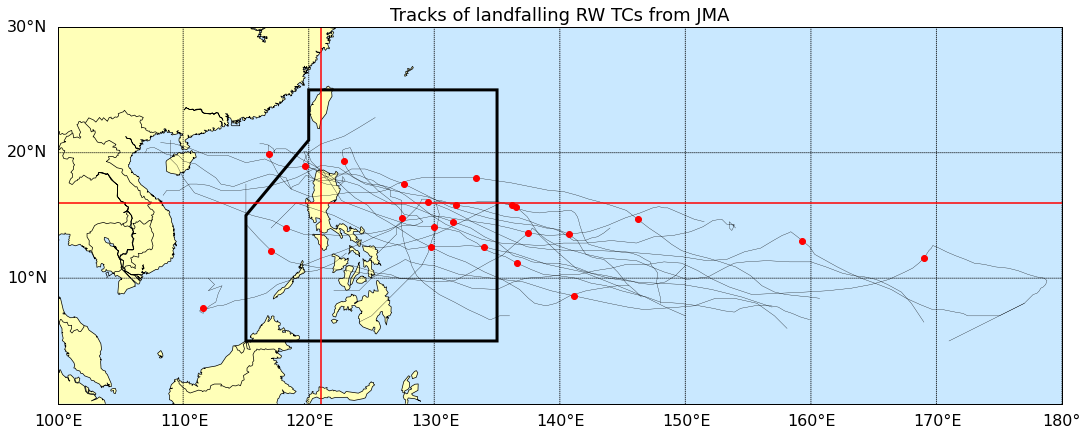

In [34]:
lan = tt2["SID"].unique().tolist()
land = jma_dat[jma_dat["SID"].isin(lan)]
rwp = jma_filtered[jma_filtered["SID"].isin(lan)]

plt.figure(figsize = (18,12))
m = Basemap(projection = 'cyl', llcrnrlat=0,urcrnrlat=30, llcrnrlon=100,urcrnrlon=180,lat_ts = 20, resolution='l')
m.drawcoastlines(linewidth = 0.7)
m.drawmapboundary(fill_color = "#c9e8ff")
m.drawcountries(linewidth = 0.7)
#m.drawstates(linewidth = 0.5)
m.fillcontinents(color='#ffffb8')
m.drawparallels(np.arange(10,90,10),labels=[1,0,0,0], fontsize = 16)
m.drawmeridians(np.arange(-180,180,10),labels=[0,0,0,1], fontsize = 16)

x1, y1 = m(115, 5)
x2, y2 = m(115, 15)
x3, y3 = m(120, 21)
x4, y4 = m(120, 25)
x5, y5 = m(125, 25)
x6, y6 = m(135, 25)
x7, y7 = m(135, 5)
x8, y8 = m(115, 5)

#x_par = [115, 115, 120, 120, 125, 135,135, 115]
#y_par =[5, 15, 21, 35, 35, 35, 5, 5]
poly = Polygon([(x1,y1), (x2,y2), (x3,y3), (x4,y4), (x5,y5), (x6,y6), (x7,y7), (x8,y8)],facecolor ="None", edgecolor='black',linewidth=3)
plt.gca().add_patch(poly)

for name, group in land.groupby("SID"):
    lat = group.TOKYO_LAT.values 
    lon = group.TOKYO_LON.values
    x,y = m(lon, lat)
    plt.plot(x,y, 'k-', linewidth = 0.3)
    
for name1, group1 in rwp.groupby("SID"):
    lat = group1.TOKYO_LAT.values 
    lon = group1.TOKYO_LON.values
    x1,y1 = m(lon, lat)
    plt.plot(x1,y1, 'ro', linewidth = 0.3)
    
plt.axhline(y=16, color='r', linestyle='-')  
plt.axvline(x=121, color='r', linestyle='-')
plt.title("Tracks of landfalling RW TCs from JMA", fontsize = 18)
plt.show()

In [35]:
st_luzon = land2[(land2["DIST2LAND"] >= 0) & (land2["DIST2LAND"] <= 25.4)
                & (land2["TOKYO_LAT"] >= 16) & (land2["TOKYO_LON"] >= 115)].index #115
luztc = land2.loc[st_luzon]
luztc.SID.nunique()

7

In [36]:
luz_int = luztc.groupby("SID").first().reset_index()
avel_int = luz_int["TOKYO_WIND"].mean()
avel_int

53.88286922182151

In [37]:
st_luzon2 = land1[(land1["DIST2LAND"] >= 0) & (land1["DIST2LAND"] <= 25.4)
                & (land1["TOKYO_LAT"] >= 16) & (land1["TOKYO_LON"] >= 115)].index #115
luztc2 = land1.loc[st_luzon2]
luztc2.SID.nunique()

153

In [38]:
st_vm = land2[(land2["DIST2LAND"] >= 0)  & (land2["TOKYO_LAT"] < 16)  
              & (land2["DIST2LAND"] <= 25.4)  & (land2["TOKYO_LON"] >= 115) ].index
vmtc = land2.loc[st_vm]
vmtc.SID.nunique()

10

In [39]:
st_vm2 = land1[(land1["DIST2LAND"] >= 0)  & (land1["TOKYO_LAT"] < 16)  
              & (land1["DIST2LAND"] <= 25.4)  & (land1["TOKYO_LON"] >= 115) ].index
vmtc2 = land1.loc[st_vm2]
vmtc2.SID.nunique()

276

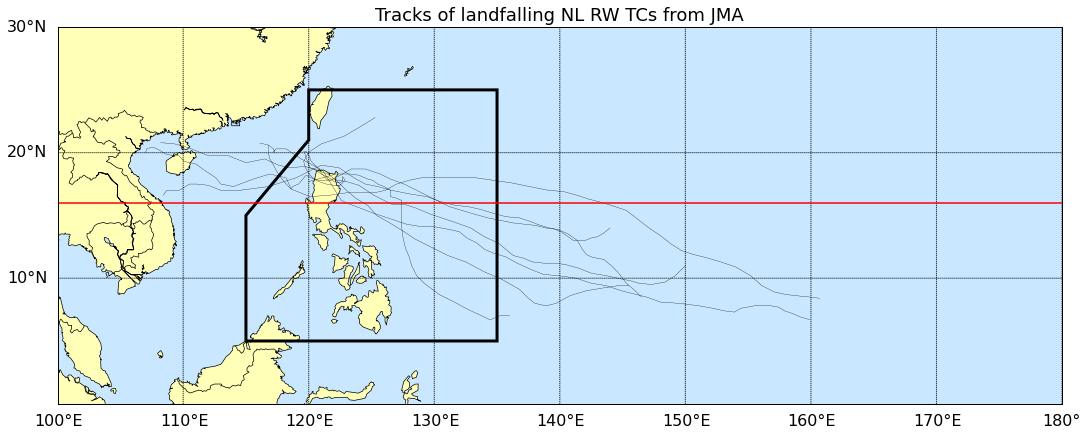

In [40]:
lan = luztc["SID"].unique().tolist()
land = jma_dat[jma_dat["SID"].isin(lan)]
rwp = jma_filtered[jma_filtered["SID"].isin(lan)]

plt.figure(figsize = (18,12))
m = Basemap(projection = 'cyl', llcrnrlat=0,urcrnrlat=30, llcrnrlon=100,urcrnrlon=180,lat_ts = 20, resolution='l')
m.drawcoastlines(linewidth = 0.7)
m.drawmapboundary(fill_color = "#c9e8ff")
m.drawcountries(linewidth = 0.7)
#m.drawstates(linewidth = 0.5)
m.fillcontinents(color='#ffffb8')
m.drawparallels(np.arange(10,90,10),labels=[1,0,0,0], fontsize = 16)
m.drawmeridians(np.arange(-180,180,10),labels=[0,0,0,1], fontsize = 16)

x1, y1 = m(115, 5)
x2, y2 = m(115, 15)
x3, y3 = m(120, 21)
x4, y4 = m(120, 25)
x5, y5 = m(125, 25)
x6, y6 = m(135, 25)
x7, y7 = m(135, 5)
x8, y8 = m(115, 5)

#x_par = [115, 115, 120, 120, 125, 135,135, 115]
#y_par =[5, 15, 21, 35, 35, 35, 5, 5]
poly = Polygon([(x1,y1), (x2,y2), (x3,y3), (x4,y4), (x5,y5), (x6,y6), (x7,y7), (x8,y8)],facecolor ="None", edgecolor='black',linewidth=3)
plt.gca().add_patch(poly)

for name, group in land.groupby("SID"):
    lat = group.TOKYO_LAT.values 
    lon = group.TOKYO_LON.values
    x,y = m(lon, lat)
    plt.plot(x,y, 'k-', linewidth = 0.3)
    
    
plt.axhline(y=16, color='r', linestyle='-')  
#plt.axvline(x=121, color='r', linestyle='-')
plt.title("Tracks of landfalling NL RW TCs from JMA", fontsize = 18)
plt.show()

In [41]:
rw_luzi = luztc["SID"].unique().tolist()
rw_luz = jma_dat[jma_dat["SID"].isin(rw_luzi)]
rw_luzx = rw_luz.groupby("SID").first().reset_index()

rw_vmi = vmtc["SID"].unique().tolist()
rw_vm = jma_dat[jma_dat["SID"].isin(rw_vmi)]
rw_vmx = rw_vm.groupby("SID").first().reset_index()

nonrw_luzi = luztc2["SID"].unique().tolist()
nonrw_luz = jma_dat[jma_dat["SID"].isin(nonrw_luzi)]
nonrw_luzx = nonrw_luz.groupby("SID").first().reset_index()

nonrw_vmi = vmtc2["SID"].unique().tolist()
nonrw_vm = jma_dat[jma_dat["SID"].isin(nonrw_vmi)]
nonrw_vmx = nonrw_vm.groupby("SID").first().reset_index()

In [42]:
jja_nonrwlz = nonrw_luzx[(nonrw_luzx["month"] == "Jun") | (nonrw_luzx["month"] == "Jul") | (nonrw_luzx["month"] == "Aug")]
son_nonrwlz = nonrw_luzx[(nonrw_luzx["month"] == "Sep") | (nonrw_luzx["month"] == "Oct") | (nonrw_luzx["month"] == "Nov")]
djf_nonrwlz = nonrw_luzx[(nonrw_luzx["month"] == "Dec") | (nonrw_luzx["month"] == "Jan") | (nonrw_luzx["month"] == "Feb")]
mam_nonrwlz = nonrw_luzx[(nonrw_luzx["month"] == "Mar") | (nonrw_luzx["month"] == "Apr") | (nonrw_luzx["month"] == "May")]

In [43]:
jja_nonrwvm = nonrw_vmx[(nonrw_vmx["month"] == "Jun") | (nonrw_vmx["month"] == "Jul") | (nonrw_vmx["month"] == "Aug")]
son_nonrwvm = nonrw_vmx[(nonrw_vmx["month"] == "Sep") | (nonrw_vmx["month"] == "Oct") | (nonrw_vmx["month"] == "Nov")]
djf_nonrwvm = nonrw_vmx[(nonrw_vmx["month"] == "Dec") | (nonrw_vmx["month"] == "Jan") | (nonrw_vmx["month"] == "Feb")]
mam_nonrwvm = nonrw_vmx[(nonrw_vmx["month"] == "Mar") | (nonrw_vmx["month"] == "Apr") | (nonrw_vmx["month"] == "May")]

In [44]:
jja_rwvm = rw_vmx[(rw_vmx["month"] == "Jun") | (rw_vmx["month"] == "Jul") | (rw_vmx["month"] == "Aug")]
son_rwvm = rw_vmx[(rw_vmx["month"] == "Sep") | (rw_vmx["month"] == "Oct") | (rw_vmx["month"] == "Nov")]
djf_rwvm = rw_vmx[(rw_vmx["month"] == "Dec") | (rw_vmx["month"] == "Jan") | (rw_vmx["month"] == "Feb")]
mam_rwvm = rw_vmx[(rw_vmx["month"] == "Mar") | (rw_vmx["month"] == "Apr") | (rw_vmx["month"] == "May")]

In [45]:
jja_rwlz = rw_luzx[(rw_luzx["month"] == "Jun") | (rw_luzx["month"] == "Jul") | (rw_luzx["month"] == "Aug")]
son_rwlz = rw_luzx[(rw_luzx["month"] == "Sep") | (rw_luzx["month"] == "Oct") | (rw_luzx["month"] == "Nov")]
djf_rwlz = rw_luzx[(rw_luzx["month"] == "Dec") | (rw_luzx["month"] == "Jan") | (rw_luzx["month"] == "Feb")]
mam_rwlz = rw_luzx[(rw_luzx["month"] == "Mar") | (rw_luzx["month"] == "Apr") | (rw_luzx["month"] == "May")]

In [46]:
print(jja_nonrwlz.SID.nunique())
print(son_nonrwlz.SID.nunique())
print(djf_nonrwlz.SID.nunique())
print(mam_nonrwlz.SID.nunique())

69
72
1
11


In [47]:
sl1 = rw_vmx["SID"].unique().tolist()
l1 = landfall_tcs[landfall_tcs["SID"].isin(sl1)]
l1_pdi = l1["V3"].sum()
print(l1_pdi)
print(l1_pdi/len(l1))

1013829.3512946402
42242.889637276676


In [48]:
s1 = rw_luzx["SID"].unique().tolist()
tc1 = landfall_tcs[landfall_tcs["SID"].isin(s1)]
tc1_pdi = tc1["V3"]

s2 = nonrw_luzx["SID"].unique().tolist()
tc2 = landfall_tcs[landfall_tcs["SID"].isin(s2)]
tc2_pdi = tc2["V3"]

In [49]:
mannwhitneyu(tc2_pdi, tc1_pdi)

MannwhitneyuResult(statistic=3874.0, pvalue=0.9177550974651687)

In [50]:
s3 = rw_vmx["SID"].unique().tolist()
tc3 = landfall_tcs[landfall_tcs["SID"].isin(s3)]
tc3_pdi = tc3["V3"]

s4 = nonrw_vmx["SID"].unique().tolist()
tc4 = landfall_tcs[landfall_tcs["SID"].isin(s4)]
tc4_pdi = tc4["V3"]

In [51]:
mannwhitneyu(tc3_pdi, tc4_pdi)

MannwhitneyuResult(statistic=5686.0, pvalue=2.882690380418503e-05)

In [52]:
stats.shapiro(tc1_pdi) #not normally distributed

ShapiroResult(statistic=0.8962730765342712, pvalue=0.017958594486117363)

In [53]:
stats.shapiro(tc2_pdi) #not normally distributed

ShapiroResult(statistic=0.7722574472427368, pvalue=5.276951865755157e-21)

In [54]:
stats.levene(tc1_pdi,tc2_pdi)

LeveneResult(statistic=0.21414314178184876, pvalue=0.6438276488018662)

In [55]:
tc2.SID.nunique()

153

In [56]:
print(len(l1))

24


In [57]:
parma = l1[l1["NAME"] == "PARMA"]
parma["V3"].sum()

0.0

In [58]:
parma.shape

(0, 49)

In [59]:
7110485**(1/3)

192.2942987390005

## Statistics

In [60]:
month_f = jma_dat.groupby("SID").first().reset_index()
mon_tcfreq = month_f["SID"].unique().tolist()
month_freq =  month_f[month_f["SID"].isin(mon_tcfreq)]

rw_f = jma_filtered.groupby("SID").first().reset_index()
rw_tcfreq = rw_f["SID"].unique().tolist()
rw_freq = rw_f[rw_f["SID"].isin(rw_tcfreq)] 

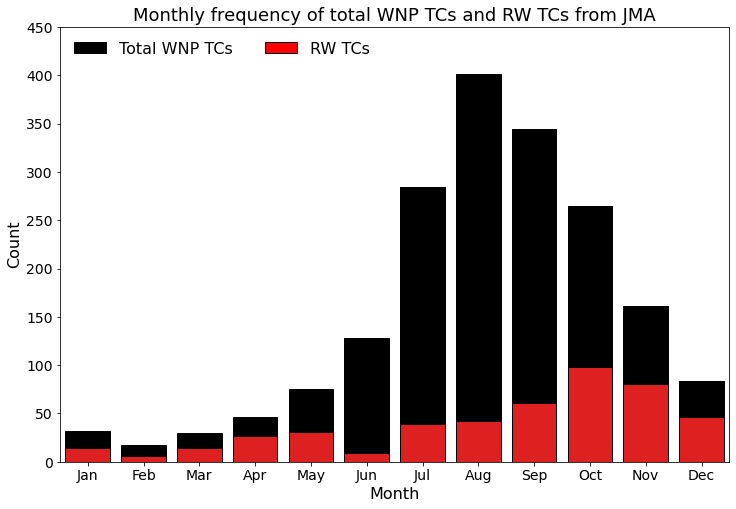

In [61]:
ncount = len(rw_freq)
plt.figure(figsize = (12,8))
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
ax_tot = sns.countplot(x="month",data = month_freq, order = month_order, color ="black", edgecolor = "black")
plt.xlabel("Month")

ax_rw = sns.countplot(x="month",data = rw_freq, order = month_order, color ="red", edgecolor = "black")

topbar = plt.Rectangle((0,0),1,1,fc="black", edgecolor = 'black')
bottombar = plt.Rectangle((0,0),1,1,fc='red',  edgecolor = 'black')
l = plt.legend([topbar, bottombar], ['Total WNP TCs', 'RW TCs'], loc= 2, ncol = 2, prop={'size':16})
l.draw_frame(False)

ax_tot.set_ylim(0,450)
plt.ylabel("Count", fontsize = 16)
plt.xlabel("Month", fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.title("Monthly frequency of total WNP TCs and RW TCs from JMA",fontsize = 18)
plt.show()



In [62]:
tot_lan =  jma_dat.groupby("SID").first().reset_index()
total =  landfall_tcs["SID"].unique().tolist()
total_lf =  tot_lan[tot_lan["SID"].isin(total)]

rw_lan = tt2.groupby("SID").first().reset_index()
rw_tot = tt2["SID"].unique().tolist()
rw_lf = rw_lan[rw_lan["SID"].isin(rw_tot)] 

In [63]:
rw_lf

,SID,SEASON,NUMBER,BASIN,SUBBASIN,NAME,ISO_TIME,NATURE,LAT,LON,...,wind_12,wind_6,d1,d2,d3,d4,dist_24h,dist_18h,dist_12h,dist_6h
0,1957101N05136,1957,29,WP,MM,SHIRLEY,1957-04-15 00:00:00,TS,14.7333,127.450,...,57.767838,62.730655,0.000000,-4.962817,-5.375044,-15.499842,404.0,410.0,399.0,378.0
1,1964187N07150,1964,41,WP,MM,CORA,1964-07-07 18:00:00,TS,12.3289,133.957,...,67.363658,67.363658,0.000000,0.000000,-9.595820,-11.286118,408.0,508.0,629.0,767.0
2,1965101N06158,1965,37,WP,MM,WANDA,1965-04-14 00:00:00,TS,8.6280,141.248,...,14.483145,28.498167,-9.888402,-14.015022,0.000000,-3.352272,730.0,937.0,1178.0,1171.0
3,1967283N11150,1967,120,WP,MM,CARLA,1967-10-15 00:00:00,TS,14.5143,131.729,...,103.493798,109.383254,-5.605797,-5.889456,-6.221100,-6.616008,325.0,408.0,510.0,608.0
4,1973278N13144,1973,109,WP,MM,PATSY,1973-10-10 00:00:00,TS,15.8857,131.714,...,103.493798,109.383254,-8.314340,-5.889456,-16.318974,-11.317345,414.0,497.0,605.0,709.0
5,1977352N05171,1977,118,WP,MM,MARY,1977-12-25 06:00:00,TS,11.8037,169.118,...,80.000000,85.000000,0.000000,-5.000000,-10.000000,-5.000000,2128.0,2226.0,2312.0,2388.0
6,1981317N14153,1981,105,WP,MM,HAZEN,1981-11-16 00:00:00,TS,13.4400,140.840,...,65.000000,70.000000,0.000000,-5.000000,-5.000000,-10.000000,1023.0,1164.0,1302.0,1469.0
7,1981343N05150,1981,114,WP,MM,KIT,1981-12-17 12:00:00,TS,15.8400,136.220,...,95.000000,100.000000,0.000000,-5.000000,-5.000000,-15.000000,976.0,1058.0,1127.0,1179.0
8,1982325N08176,1982,101,WP,MM,PAMELA,1982-11-28 12:00:00,TS,13.0400,159.240,...,80.000000,90.000000,0.000000,-10.000000,-15.000000,-10.000000,1968.0,2006.0,2015.0,2013.0
9,1983321N11111,1983,84,WP,MM,PERCY,1983-11-21 00:00:00,TS,7.5600,111.460,...,60.000000,70.000000,0.000000,-10.000000,0.000000,-10.000000,395.0,408.0,419.0,426.0


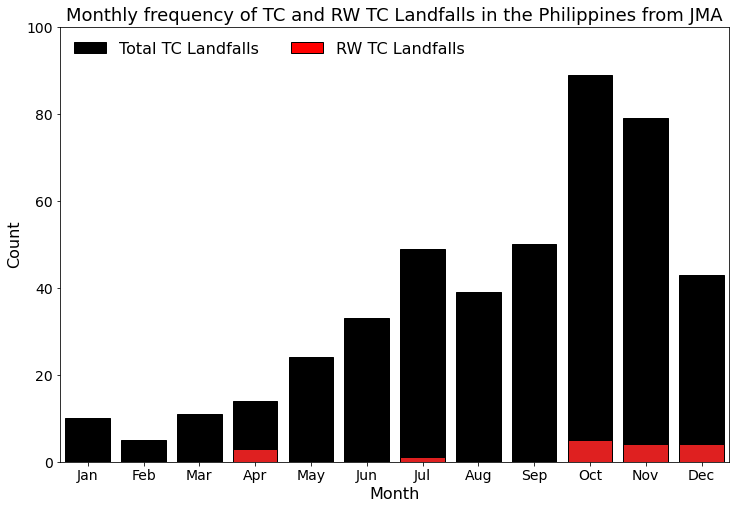

In [64]:
ncount = len(rw_lf)
plt.figure(figsize = (12,8))
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
ax_tot = sns.countplot(x="month",data = total_lf, order = month_order, color ="black", edgecolor = "black")
plt.xlabel("Month")

ax_rw = sns.countplot(x="month",data = rw_lf, order = month_order, color ="red", edgecolor = "black")

topbar = plt.Rectangle((0,0),1,1,fc="black", edgecolor = 'black')
bottombar = plt.Rectangle((0,0),1,1,fc='red',  edgecolor = 'black')
l = plt.legend([topbar, bottombar], ['Total TC Landfalls', 'RW TC Landfalls'], loc= 2, ncol = 2, prop={'size':16})
l.draw_frame(False)


ax_tot.set_ylim(0,100)
plt.ylabel("Count", fontsize = 16)
plt.xlabel("Month", fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.title("Monthly frequency of TC and RW TC Landfalls in the Philippines from JMA",fontsize = 18)
plt.show()



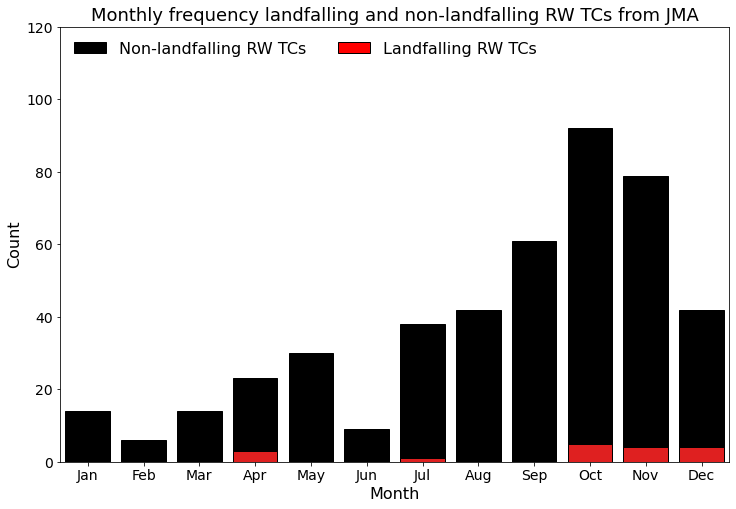

In [65]:
lf_ind = land_rwtcs["SID"].unique().tolist()
nonlandfall_rw = jma_filtered[~jma_filtered["SID"].isin(lf_ind)]
nonlandfall_rw.SID.nunique()
nonland_ind = nonlandfall_rw["SID"].unique().tolist()
nonlandfalling_rw = jma_lon[jma_lon["SID"].isin(nonland_ind)]
nonlandfall_rw1 = nonlandfall_rw.drop_duplicates(subset = ["SID"])
land_rwtcs1 = rw_lf #land_rwtcs.drop_duplicates(subset = ["SID"])


ncount = len(rw_lf)
plt.figure(figsize = (12,8))
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.xlabel("Month")

ax_rw = sns.countplot(x="month",data = nonlandfall_rw1, order = month_order, color ="black", edgecolor = "black")

ax_rwtc = sns.countplot(x="month",data = land_rwtcs1, order = month_order, color ="red", edgecolor = "black")

topbar = plt.Rectangle((0,0),1,1,fc="black", edgecolor = 'black')
bottombar = plt.Rectangle((0,0),1,1,fc='red',  edgecolor = 'black')
l = plt.legend([topbar, bottombar], ['Non-landfalling RW TCs', 'Landfalling RW TCs'], loc= 2, ncol = 2, prop={'size':16})
l.draw_frame(False)

plt.ylim(0,120)
plt.ylabel("Count", fontsize = 16)
plt.xlabel("Month", fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.title("Monthly frequency landfalling and non-landfalling RW TCs from JMA",fontsize = 18)
plt.show()



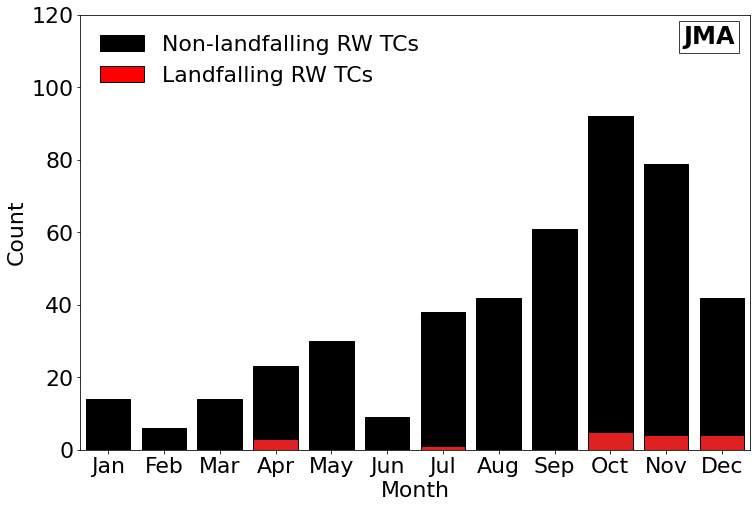

In [66]:
lf_ind = land_rwtcs["SID"].unique().tolist()
nonlandfall_rw = jma_filtered[~jma_filtered["SID"].isin(lf_ind)]
nonlandfall_rw.SID.nunique()
nonland_ind = nonlandfall_rw["SID"].unique().tolist()
nonlandfalling_rw = jma_lon[jma_lon["SID"].isin(nonland_ind)]
nonlandfall_rw1 = nonlandfall_rw.drop_duplicates(subset = ["SID"])
land_rwtcs1 = rw_lf #land_rwtcs.drop_duplicates(subset = ["SID"])


ncount = len(rw_lf)
plt.figure(figsize = (12,8))
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.xlabel("Month")

ax_rw = sns.countplot(x="month",data = nonlandfall_rw1, order = month_order, color ="black", edgecolor = "black")

ax_rwtc = sns.countplot(x="month",data = land_rwtcs1, order = month_order, color ="red", edgecolor = "black")

topbar = plt.Rectangle((0,0),1,1,fc="black", edgecolor = 'black')
bottombar = plt.Rectangle((0,0),1,1,fc='red',  edgecolor = 'black')
l = plt.legend([topbar, bottombar], ['Non-landfalling RW TCs', 'Landfalling RW TCs'], loc= 2, ncol = 1, prop={'size':22})
l.draw_frame(False)

text3 = f"JMA"
#text3 = f"$y={z3[0]:0.3f}\;x{z3[1]:+0.3f}$\n$p = {0.000:0.3f}$"
t3 = plt.text(10.3, 112, text3, fontsize = 24, fontweight = "bold")
t3.set_bbox(dict(facecolor = "w", alpha = 0.75, edgecolor = "k"))

plt.ylim(0,120)
plt.ylabel("Count", fontsize = 22)
plt.xlabel("Month", fontsize = 22)
plt.xticks(fontsize = 22)
plt.yticks(fontsize = 22)
#plt.title("Monthly frequency landfalling and non-landfalling RW TCs from JMA",fontsize = 18)
plt.show()



### TC trend

In [67]:
TC = jma_dat.groupby("SID").first().reset_index()
tc_year = TC["SEASON"].value_counts().to_frame().reset_index()
tc_year = tc_year.sort_values(by = "index")
tc_year = tc_year.reset_index(drop=True)

counts = tc_year.SEASON.values
year = tc_year["index"].values

#----------------------------------

sat = TC[TC["SEASON"] >= 1978].index
sat_TC = TC.loc[sat]
tc_year1978 = sat_TC["SEASON"].value_counts().to_frame().reset_index()
tc_year1978 = tc_year1978.sort_values(by = "index")
tc_year1978 = tc_year1978.reset_index(drop=True)

year1978 = tc_year1978["index"].values
counts1978 = tc_year1978.SEASON.values

#----------------------------------

#number of RW TCs in WNP
land_TC = jma_data.groupby("SID").first().reset_index()
landrwtc_year = land_TC["SEASON"].value_counts().to_frame().reset_index()
landrwtc_year = landrwtc_year.sort_values(by = "index")
landrwtc_year = landrwtc_year.reset_index(drop=True)

year_rw = landrwtc_year["index"].values
count_rw = landrwtc_year.SEASON.values

#----------------------------------

sat_rw = land_TC[land_TC["SEASON"] >= 1978].index
sat_rwtc = land_TC.loc[sat_rw]
satrw_1978 = sat_rwtc["SEASON"].value_counts().to_frame().reset_index()
satrw_1978 = satrw_1978.sort_values(by = "index")
satrw_1978 = satrw_1978.reset_index(drop=True)

year_rw1978 = satrw_1978["index"].values
count_rw1978 = satrw_1978.SEASON.values

#----------------------------------

model = smf.ols("year ~ counts", data = tc_year).fit()
model2 = smf.ols("year1978 ~ counts1978", data = tc_year1978).fit()
model3 = smf.ols("year_rw ~ count_rw", data = landrwtc_year).fit()
model4 = smf.ols("year_rw1978 ~ count_rw1978", data = satrw_1978).fit()

Text(0.5, 1.0, 'Frequency of TC and RW TC Genesis in the WNP from JMA')

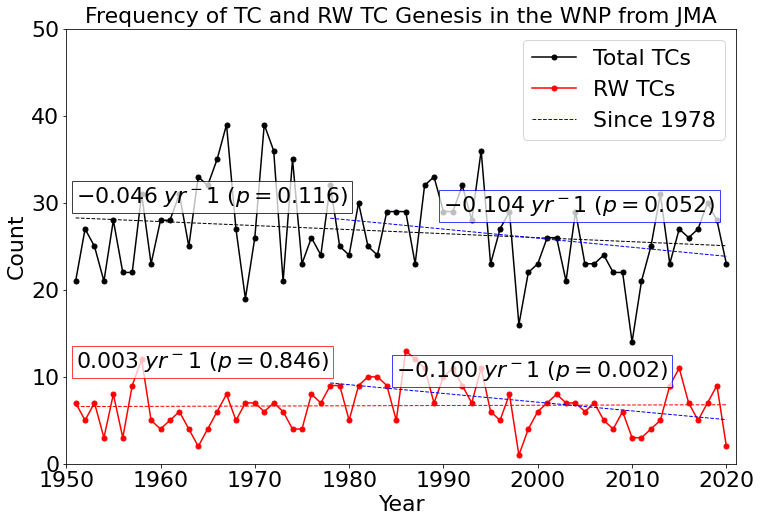

In [68]:
plt.figure(figsize = (12,8))
plt.plot(year,counts,"k.-", ms=10, mec="k", label = "Total TCs")
z = np.polyfit(year, counts, 1)
y_hat = np.poly1d(z)(year)

                      
plt.plot(year, y_hat, "k--", lw=1)
text1 = f"${z[0]:0.3f}\; yr^{-1}$ $(p = {round(model.pvalues[1], 3):0.3f})$"
t1 = plt.text(1951, 30, text1, fontsize = 22)
t1.set_bbox(dict(facecolor = "w", alpha = 0.75, edgecolor = "k"))
#plt.gca().text(0.05, 0.95, text1,transform=plt.gca().transAxes,
     #fontsize=10, verticalalignment='top')

z2 = np.polyfit(year1978, counts1978, 1)
y_hat2 = np.poly1d(z2)(year1978)
plt.plot(year1978, y_hat2, "b--", lw=1)
text2 = f"${z2[0]:0.3f}\; yr^{-1}$ $(p = {round(model2.pvalues[1], 3):0.3f})$"
#text2 = f"$y={z2[0]:0.3f}\;x{z2[1]:+0.3f}$\n$p = {0.066:0.3f}$"
t2 = plt.text(1990, 29, text2, fontsize = 22)
t2.set_bbox(dict(facecolor = "w", alpha = 0.75, edgecolor = "b"))

#######

plt.plot(year_rw, count_rw, "r.-", ms=10, mec="r", label = "RW TCs")
z3 = np.polyfit(year_rw, count_rw, 1)
y_hat3 = np.poly1d(z3)(year_rw)

plt.plot(year_rw, y_hat3, "r--", lw=1)
text3 = f"${z3[0]:0.3f}\; yr^{-1}$ $(p = {round(model3.pvalues[1], 3):0.3f})$"
#text3 = f"$y={z3[0]:0.3f}\;x{z3[1]:+0.3f}$\n$p = {0.000:0.3f}$"
t3 = plt.text(1951, 11, text3, fontsize = 22)
t3.set_bbox(dict(facecolor = "w", alpha = 0.75, edgecolor = "red"))

z4 = np.polyfit(year_rw1978, count_rw1978, 1)
y_hat4 = np.poly1d(z4)(year_rw1978)
plt.plot(year_rw1978, y_hat4, "b--", lw=1, label = "Since 1978")
text4 = f"${z4[0]:0.3f}\; yr^{-1}$ $(p = {round(model4.pvalues[1], 3):0.3f})$"
#text4 = f"$y={z4[0]:0.3f}\;x{z4[1]:+0.3f}$\n$p = {0.103:0.3f}$"
t4 = plt.text(1985, 10, text4, fontsize = 22)
t4.set_bbox(dict(facecolor = "w", alpha = 0.75, edgecolor = "b"))

plt.legend(fontsize = 22)
plt.xlim(1950,2021)
plt.xlabel("Year", fontsize = 22)
plt.ylabel("Count", fontsize = 22)
plt.ylim(0, 50)
plt.xticks(fontsize = 22)
plt.yticks(fontsize = 22)
plt.title("Frequency of TC and RW TC Genesis in the WNP from JMA", fontsize = 22)

In [69]:
landrwtc_year["ratio"] = (landrwtc_year["SEASON"]/tc_year.SEASON)*100
ratio = landrwtc_year.ratio.values
ratio_tc = landrwtc_year[["index", "ratio"]]

satrw_1978["ratio"] = (satrw_1978.SEASON/tc_year1978.SEASON)*100
ratio1978 = satrw_1978.ratio.values
satrw_1978ratio = satrw_1978[["index", "ratio"]]

modelr = smf.ols("year_rw ~ ratio", data = ratio_tc).fit()
modelr1978 = smf.ols("year_rw1978 ~ ratio1978", data = satrw_1978ratio).fit()

Text(0.5, 1.0, 'Ratio of RW TCs to Total WNP TCs from JMA')

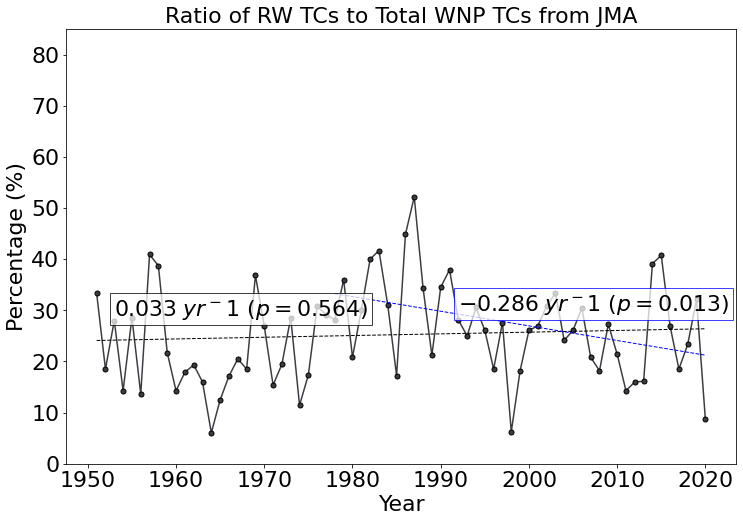

In [70]:
plt.figure(figsize = (12,8))
plt.plot(year_rw, ratio, color = "#3a3d42" ,linestyle = "-", marker= ".", ms=10, mec="k", label = "Total TCs")
zr = np.polyfit(year_rw, ratio, 1)
y_hatr = np.poly1d(zr)(year_rw)

                      
plt.plot(year_rw, y_hatr, "k--", lw=1)
textr = f"${zr[0]:0.3f}\; yr^{-1}$ $(p = {round(modelr.pvalues[1], 3):0.3f})$"
tr = plt.text(1953, 29, textr, fontsize = 22)
tr.set_bbox(dict(facecolor = "w", alpha = 0.75, edgecolor = "k"))


zr1978 = np.polyfit(year_rw1978, ratio1978, 1)
y_hatr1978 = np.poly1d(zr1978)(year_rw1978)
plt.plot(year_rw1978, y_hatr1978, "b--", lw=1)
textr1978 = f"${zr1978[0]:0.3f}\; yr^{-1}$ $(p = {round(modelr1978.pvalues[1], 3):0.3f})$"
tr1978 = plt.text(1992, 30, textr1978, fontsize = 22)
tr1978.set_bbox(dict(facecolor = "w", alpha = 0.75, edgecolor = "b"))
plt.xlabel("Year", fontsize = 22)
plt.ylabel("Percentage (%)", fontsize = 22)
plt.xticks(fontsize = 22)
plt.yticks(fontsize = 22)
plt.ylim(0, 85)
plt.title("Ratio of RW TCs to Total WNP TCs from JMA", fontsize = 22)

### Mean drop during landfall

In [71]:
#par_ind = jtwc_data[(jtwc_data["DIST2LAND"] >=0) & (jtwc_data["DIST2LAND"] <= 25.4) & (jtwc_data["USA_LON"] < 135) & (jtwc_data["USA_LON"] > 115) & (jtwc_data["USA_LAT"]>5) & (jtwc_data["USA_LAT"] <21)].index
#par_ind = jma_dat[(jma_dat["DIST2LAND"] >=0) & (jma_dat["TOKYO_LON"] <= 135) & (jma_dat["TOKYO_LON"] >= 115) & (jma_dat["TOKYO_LAT"] >= 5) & (jma_dat["TOKYO_LAT"] <= 25)].index
par_ind = jma_dat[(jma_dat["DIST2LAND"] >=0) & (jma_dat["TOKYO_LON"] <= 130) & (jma_dat["TOKYO_LON"] >= 115) & (jma_dat["TOKYO_LAT"] >= 5) & (jma_dat["TOKYO_LAT"] <= 20)].index
par_tcs = jma_dat.loc[par_ind]
par_sid = par_tcs["SID"].unique().tolist()
partc = jma_dat[jma_dat["SID"].isin(par_sid)]

par_tcs["percent_drop"] = (par_tcs["diff_6h"].abs()/par_tcs["TOKYO_WIND"])*100

jmapar_ind = partc[partc["SEASON"] == 2015].index
jmapar = partc.loc[jmapar_ind]
print(jmapar.NAME.unique())

['MEKKHALA' 'BAVI' 'MAYSAK' 'NOUL' 'LINFA' 'GONI' 'MUJIGAE' 'KOPPU'
 'MELOR']


In [72]:
jma_dat.shape

(57659, 48)

In [73]:
par_tcs["wind_6h"] = par_tcs["TOKYO_WIND"].shift(-1)
par_tcs[["NAME", "ISO_TIME", "DIST2LAND", "dist_6h","wind_6h","TOKYO_WIND", "TOKYO_LON", "TOKYO_LAT"]]

,NAME,ISO_TIME,DIST2LAND,dist_6h,wind_6h,TOKYO_WIND,TOKYO_LON,TOKYO_LAT
152,HOPE,1951-04-22 12:00:00,568,500.0,32.072294,32.072294,129.4,15.5
154,HOPE,1951-04-22 18:00:00,500,437.0,24.523240,32.072294,128.7,15.6
156,HOPE,1951-04-23 00:00:00,437,411.0,22.335500,24.523240,127.9,15.9
158,HOPE,1951-04-23 06:00:00,411,444.0,14.483145,22.335500,127.2,16.2
160,HOPE,1951-04-23 12:00:00,444,454.0,14.483145,14.483145,127.0,17.1
...,...,...,...,...,...,...,...,...
126017,KROVANH,2020-12-19 06:00:00,113,10.0,24.523240,24.523240,119.3,9.2
126019,KROVANH,2020-12-19 12:00:00,10,117.0,24.523240,24.523240,117.7,9.9
126021,KROVANH,2020-12-19 18:00:00,117,257.0,35.000000,24.523240,116.1,9.2
126023,KROVANH,2020-12-20 00:00:00,257,309.0,35.000000,35.000000,115.7,9.6


In [74]:
#obtain mean drop in wind speed during landfall

l_ind =  par_tcs[(par_tcs["dist_6h"] <= 25.4) & (par_tcs["dist_6h"] >= 0) & (par_tcs["diff_6h"] <= 0)].index
landfall_tf = par_tcs.loc[l_ind]
#landfall_tf[["NAME", "SEASON","ISO_TIME","USA_LON", "USA_LAT", "DIST2LAND", "dist_24h", "diff_24h",]].head(60)

In [75]:
landfall_tf.SID.nunique()

420

In [76]:
mean = landfall_tf["diff_6h"].abs().mean() 
mean_per = landfall_tf["percent_drop"].mean()  
above_ind =landfall_tf[landfall_tf["diff_6h"].abs() > mean].index
above_mean = landfall_tf.loc[above_ind]
print(above_mean.SID.nunique())

abovep_ind =landfall_tf[landfall_tf["percent_drop"] > mean_per].index
abovep_mean = landfall_tf.loc[abovep_ind]
print(abovep_mean.SID.nunique())
#above_mean[["NAME", "SEASON","ISO_TIME","USA_LON", "USA_LAT", "DIST2LAND", "dist_24h", "diff_24h", "USA_WIND"]].head(60)

250
248


In [77]:
print(mean)
print(mean_per)

3.723481238834832
6.486675314364063


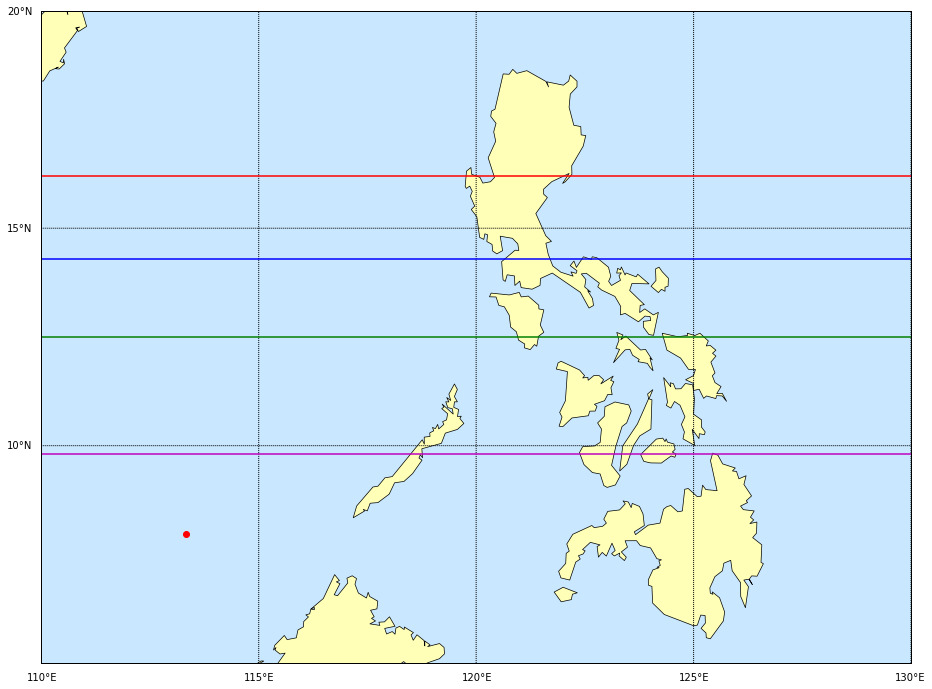

In [78]:
plt.figure(figsize = (18,12))
m = Basemap(projection = 'cyl', llcrnrlat=5,urcrnrlat=20, llcrnrlon=110,urcrnrlon=130,lat_ts = 10, resolution='l')
m.drawcoastlines(linewidth = 0.7)
m.drawmapboundary(fill_color = "#c9e8ff")
m.drawcountries(linewidth = 0.7)
#m.drawstates(linewidth = 0.5)5
m.fillcontinents(color='#ffffb8')
m.drawparallels(np.arange(10,90,5),labels=[1,0,0,0])
m.drawmeridians(np.arange(-180,180,5),labels=[0,0,0,1])

plt.axhline(y=12.5, color='g', linestyle='-')
plt.axhline(y=16.2, color='r', linestyle='-')
plt.axhline(y=14.3, color='b', linestyle='-')
plt.axhline(y=9.8, color='m', linestyle='-')

In [79]:
landfall_tff =landfall_tf.groupby("SID").first().reset_index()
landfall_tff[["NAME", "ISO_TIME", "DIST2LAND", "dist_6h","wind_6h","TOKYO_WIND", "TOKYO_LON", "TOKYO_LAT"]]

,NAME,ISO_TIME,DIST2LAND,dist_6h,wind_6h,TOKYO_WIND,TOKYO_LON,TOKYO_LAT
0,IRIS,1951-05-04 12:00:00,117,10.0,104.096776,108.229416,126.8,11.5
1,LOUISE,1951-07-29 18:00:00,81,0.0,105.886410,112.778181,123.1,16.6
2,NORA,1951-09-01 00:00:00,33,0.0,62.730655,67.363658,122.5,18.0
3,PAT,1951-09-23 18:00:00,204,24.0,32.072294,32.072294,124.3,15.8
4,WANDA,1951-11-20 06:00:00,66,0.0,52.392794,52.392794,126.3,11.0
...,...,...,...,...,...,...,...,...
415,MOLAVE,2020-10-25 18:00:00,39,15.0,70.000000,70.000000,121.8,13.1
416,GONI,2020-10-31 18:00:00,64,0.0,100.000000,120.000000,125.0,13.8
417,ETAU,2020-11-07 18:00:00,33,0.0,19.971852,24.523240,122.6,13.0
418,VAMCO,2020-11-11 12:00:00,55,0.0,70.000000,75.000000,122.8,14.8


In [80]:
r1 =  landfall_tff[(landfall_tff["TOKYO_LON"] >= 115) & (landfall_tff["TOKYO_LON"] <= 130)
            & (landfall_tff["TOKYO_LAT"] >= 16.2) &  (landfall_tff["TOKYO_LAT"] <= 20) ].index
r1_tc = landfall_tff.loc[r1]
print(r1_tc.SID.nunique())

avew_r1 = r1_tc["wind_6h"].mean()
print("landfall_intensity =", avew_r1)

avei_r1 = r1_tc["diff_6h"].abs().mean() 
print("intensity_drop =",avei_r1)

avep_r1 = r1_tc["percent_drop"].mean() 
print("percent_drop =", avep_r1)

113
landfall_intensity = 57.69299949733575
intensity_drop = 3.9652660347089155
percent_drop = 5.945466001025878


In [81]:
r2 =  landfall_tff[(landfall_tff["TOKYO_LON"] >= 115) & (landfall_tff["TOKYO_LON"] <= 130)
            & (landfall_tff["TOKYO_LAT"] >= 14.3) &  (landfall_tff["TOKYO_LAT"] < 16.2) ].index
r2_tc = landfall_tff.loc[r2]
print(r2_tc.SID.nunique())

avew_r2 = r2_tc["wind_6h"].mean()
print("landfall_intensity =", avew_r2)

avei_r2 = r2_tc["diff_6h"].abs().mean() 
print("intensity_drop =",avei_r2)

avep_r2 = r2_tc["percent_drop"].mean() 
print("percent_drop =", avep_r2)

85
landfall_intensity = 49.443604893978154
intensity_drop = 4.933444060874285
percent_drop = 7.823070743101706


In [82]:
r3 =  landfall_tff[(landfall_tff["TOKYO_LON"] >= 115) & (landfall_tff["TOKYO_LON"] <= 130)
            & (landfall_tff["TOKYO_LAT"] >= 12.5) &  (landfall_tff["TOKYO_LAT"] < 14.3) ].index
r3_tc = landfall_tff.loc[r3]
print(r3_tc.SID.nunique())

avew_r3 = r3_tc["wind_6h"].mean()
print("landfall_intensity =", avew_r3)

avei_r3 = r3_tc["diff_6h"].abs().mean() 
print("intensity_drop =",avei_r3)

avep_r3 = r3_tc["percent_drop"].mean() 
print("percent_drop =", avep_r3)

75
landfall_intensity = 50.68393581708117
intensity_drop = 2.7265267266188764
percent_drop = 5.506346929902357


In [83]:
r4 =  landfall_tff[(landfall_tff["TOKYO_LON"] >= 115) & (landfall_tff["TOKYO_LON"] <= 130)
            & (landfall_tff["TOKYO_LAT"] >= 9.8) &  (landfall_tff["TOKYO_LAT"] < 12.5) ].index
r4_tc = landfall_tff.loc[r4]
print(r4_tc.SID.nunique())

avew_r4 = r4_tc["wind_6h"].mean()
print("landfall_intensity =", avew_r4)

avei_r4 = r4_tc["diff_6h"].abs().mean() 
print("intensity_drop =",avei_r4)

avep_r4 = r4_tc["percent_drop"].mean() 
print("percent_drop =", avep_r4)

98
landfall_intensity = 46.06207215041568
intensity_drop = 2.760807644905323
percent_drop = 4.985275908589748


In [84]:
r5 =  landfall_tff[(landfall_tff["TOKYO_LON"] >= 115) & (landfall_tff["TOKYO_LON"] <= 130)
            & (landfall_tff["TOKYO_LAT"] >= 0) &  (landfall_tff["TOKYO_LAT"] < 9.8) ].index
r5_tc = landfall_tff.loc[r5]
print(r5_tc.SID.nunique())

avew_r5 = r5_tc["wind_6h"].mean()
print("landfall_intensity =", avew_r5)

avei_r5 = r5_tc["diff_6h"].abs().mean() 
print("intensity_drop =",avei_r5)

avep_r5 = r5_tc["percent_drop"].mean() 
print("percent_drop =", avep_r5)

49
landfall_intensity = 36.64154377349011
intensity_drop = 2.282861750706539
percent_drop = 4.8529279351585854


In [87]:
#cordillera + sierra madre - COR-SM
# sierra madre - SM
# region IV and V - BIC
# visayas small islands - VIS
# mindanao large islands - MIN

In [88]:
jma_dat

,SID,SEASON,NUMBER,BASIN,SUBBASIN,NAME,ISO_TIME,NATURE,LAT,LON,...,wind_12,wind_6,d1,d2,d3,d4,dist_24h,dist_18h,dist_12h,dist_6h
0,1951050N20139,1951,15,WP,MM,NOT_NAMED,1951-02-19 06:00:00,TS,20.00000,138.500,...,32.072294,7.005759,0.000000,25.066534,9.163382,0.000000,1284.0,1250.0,1313.0,1455.0
2,1951050N20139,1951,15,WP,MM,NOT_NAMED,1951-02-19 12:00:00,TS,20.00000,138.500,...,41.235675,32.072294,25.066534,9.163382,0.000000,0.000000,1386.0,1284.0,1250.0,1313.0
4,1951050N20139,1951,15,WP,MM,NOT_NAMED,1951-02-19 18:00:00,TS,23.00000,142.100,...,41.235675,41.235675,9.163382,0.000000,0.000000,2.690421,1610.0,1386.0,1284.0,1250.0
6,1951050N20139,1951,15,WP,MM,NOT_NAMED,1951-02-20 00:00:00,NR,25.00000,146.000,...,41.235675,41.235675,0.000000,0.000000,2.690421,2.555623,1793.0,1610.0,1386.0,1284.0
8,1951050N20139,1951,15,WP,MM,NOT_NAMED,1951-02-20 06:00:00,NR,27.60000,150.600,...,43.926097,41.235675,0.000000,2.690421,2.555623,NaN,NaN,1793.0,1610.0,1386.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126055,2020353N06129,2020,113,WP,MM,KROVANH,2020-12-24 00:00:00,TS,7.55000,103.950,...,19.971852,24.523240,4.551388,-4.551388,-5.488707,0.000000,47.0,74.0,158.0,166.0
126057,2020353N06129,2020,113,WP,MM,KROVANH,2020-12-24 06:00:00,TS,7.65000,102.800,...,14.483145,19.971852,-4.551388,-5.488707,0.000000,NaN,NaN,47.0,74.0,158.0
126059,2020353N06129,2020,113,WP,MM,KROVANH,2020-12-24 12:00:00,TS,8.15000,101.750,...,14.483145,14.483145,-5.488707,0.000000,NaN,NaN,NaN,NaN,47.0,74.0
126061,2020353N06129,2020,113,WP,MM,KROVANH,2020-12-24 18:00:00,TS,8.65714,100.771,...,NaN,14.483145,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,47.0


In [89]:
jma_filtered["diff_24h"].abs().mean()

23.361162440453263

In [90]:
indx = tt2["SID"].unique().tolist()
drop = landfall_tff[landfall_tff["SID"].isin(indx)] #TC data of all RW TCs 

In [91]:
drop["diff_24h"].abs().mean()

16.317774130601624

In [92]:
jma_filtered["percent_drop"] = (jma_filtered["diff_24h"].abs()/jma_filtered["TOKYO_WIND"])*100
jma_filtered["percent_drop"].abs().mean()

34.19500054008675

In [93]:
indx2 = tt2["SID"].unique().tolist()
drop2 = jma_filtered[jma_filtered["SID"].isin(indx2)] #TC data of all RW TCs 
indz = drop2[(drop2["TOKYO_LON"] >= 116.5)].index
drop3 = drop2.loc[indz]
print(drop2["diff_24h"].abs().mean())
print(drop3["diff_24h"].abs().mean())

23.820765683866227
23.986885930990844


In [94]:
drop2["percent_drop"].abs().mean()

33.88497462708082